<a href="https://colab.research.google.com/github/lucacamus13/markowitz-portfolio/blob/main/markowitz_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm



In [21]:
# 1. Descargar datos de QQQ
spy = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Close']

# 2. Calcular retornos diarios y rendimiento acumulado
spy_returns = np.log(spy / spy.shift(1)).dropna()
spy_cumulative = (1 + spy_returns).cumprod()

/tmp/ipython-input-21-2004759855.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Close']
[*********************100%***********************]  1 of 1 completed


In [4]:
tickers = ['AAPL', 'AMD', 'AMZN','ASML','GGAL','INTC', 'PBR', 'TSLA', 'UNH', 'VIST']

# Descargamos los precios ajustados de cierre de los últimos 5 años
data = yf.download(tickers, start="2018-01-01", end="2025-05-01")['Close']


/tmp/ipython-input-4-20212211.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2025-05-01")['Close']
[*********************100%***********************]  10 of 10 completed


# FUNCIONES

## Rendimiento esperado (al target price)

AAPL    0.000509
AMD    -0.000342
AMZN    0.000315
ASML    0.000535
GGAL    0.001921
INTC   -0.000253
PBR     0.000759
TSLA   -0.000223
UNH     0.000874
VIST    0.001524
Name: Expected Return from Target Price, dtype: float64


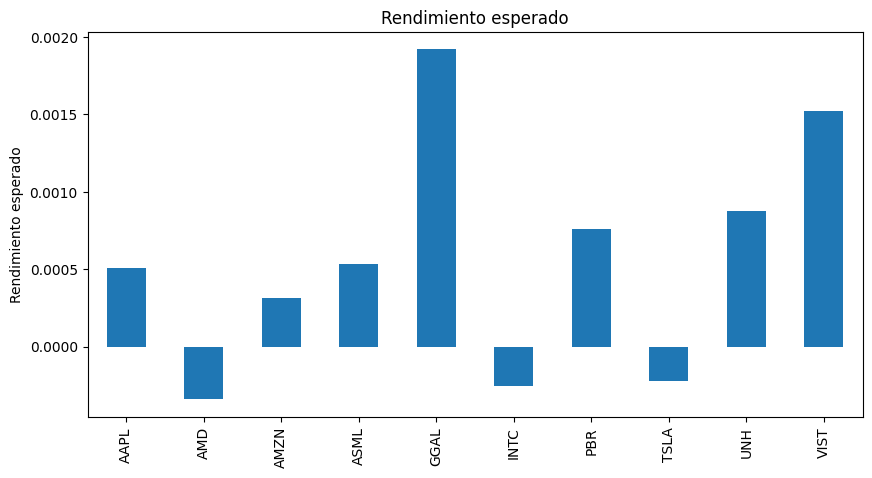

In [5]:
returns = data.pct_change().dropna()

#Calculo rendimientos por distancia al target price
expected_returns = {}

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        current_price = info.get("regularMarketPrice")
        target_price = info.get("targetMeanPrice")

        if current_price and target_price:
            expected_return = (target_price - current_price) / current_price
            expected_returns[ticker] = expected_return
        else:
            expected_returns[ticker] = None
    except Exception as e:
        expected_returns[ticker] = None
        print(f"Error con {ticker}: {e}")

# Convertir a DataFrame
expected_returns_df = pd.Series(expected_returns, name="Expected Return from Target Price")

# Convierto rendimientos anual en diario
days = 252

# Convertir retornos anuales a promedio diario con capitalización compuesta
daily_expected_returns = (1 + expected_returns_df) ** (1 / days) - 1
mean_returns = daily_expected_returns


cov_matrix = returns.cov()

print(mean_returns)
mean_returns.plot(kind='bar', figsize=(10,5), title="Rendimiento esperado")
plt.ylabel("Rendimiento esperado")
plt.show()

## Por metodologia VaR

In [6]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


In [7]:
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)


In [8]:
def min_volatility(weights, cov_matrix):
    return portfolio_volatility(weights, cov_matrix)


# ANALISIS INDIVIDUAL

## Clasificación por industria


In [9]:
# Descargar información y clasificar por industria
industries = {}
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        industries[ticker] = info.get("industry", "N/A")
    except Exception as e:
        industries[ticker] = "Error"

# Convertir a DataFrame
industries_df = pd.Series(industries, name="Industry").to_frame()
industries_df.index.name = "Ticker"

print(industries_df)


                                   Industry
Ticker                                     
AAPL                   Consumer Electronics
AMD                          Semiconductors
AMZN                        Internet Retail
ASML    Semiconductor Equipment & Materials
GGAL                       Banks - Regional
INTC                         Semiconductors
PBR                    Oil & Gas Integrated
TSLA                     Auto Manufacturers
UNH                        Healthcare Plans
VIST                          Oil & Gas E&P


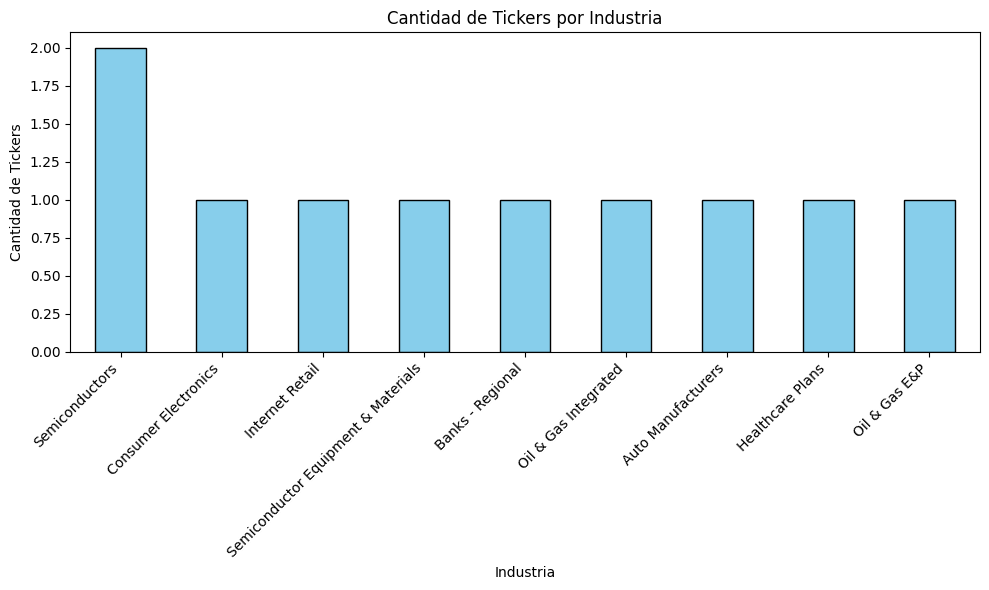

In [10]:

# Contar cuántos tickers hay por industria
industry_counts = industries_df["Industry"].value_counts()

# Graficar
plt.figure(figsize=(10,6))
industry_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Cantidad de Tickers por Industria")
plt.xlabel("Industria")
plt.ylabel("Cantidad de Tickers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Retornos acumulados

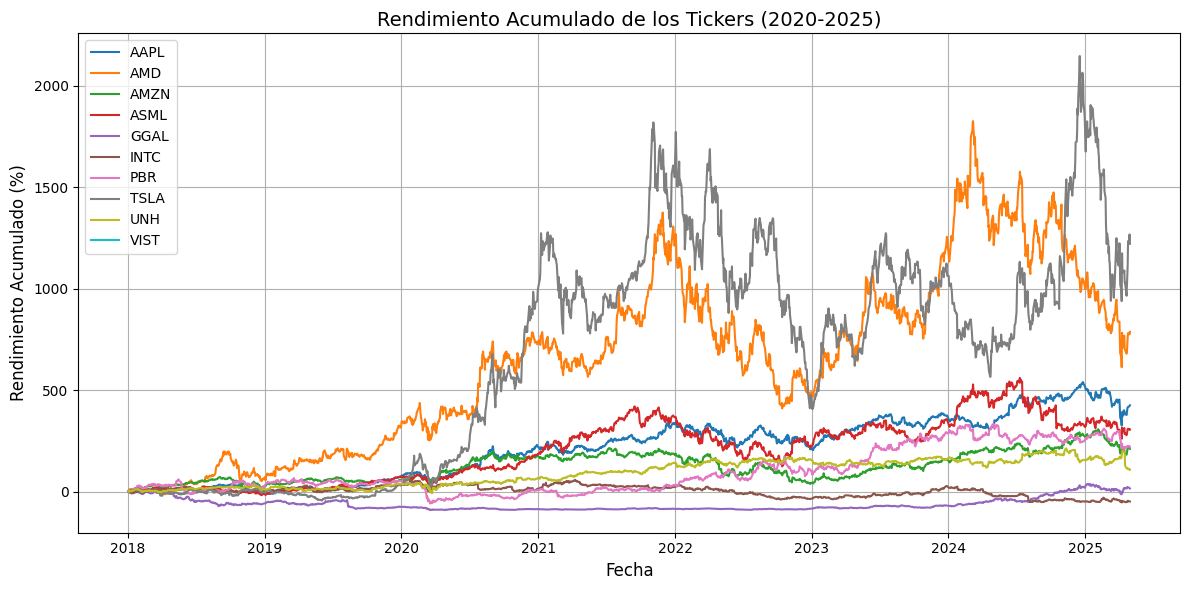

In [11]:
# Calcular el rendimiento acumulado para cada ticker
cumulative_returns = (data / data.iloc[0] - 1) * 100  # Normalizamos al precio inicial y convertimos a porcentaje

# Crear el gráfico
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

# Personalizar el gráfico
plt.title('Rendimiento Acumulado de los Tickers (2020-2025)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Rendimiento Acumulado (%)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()



## Histogramas

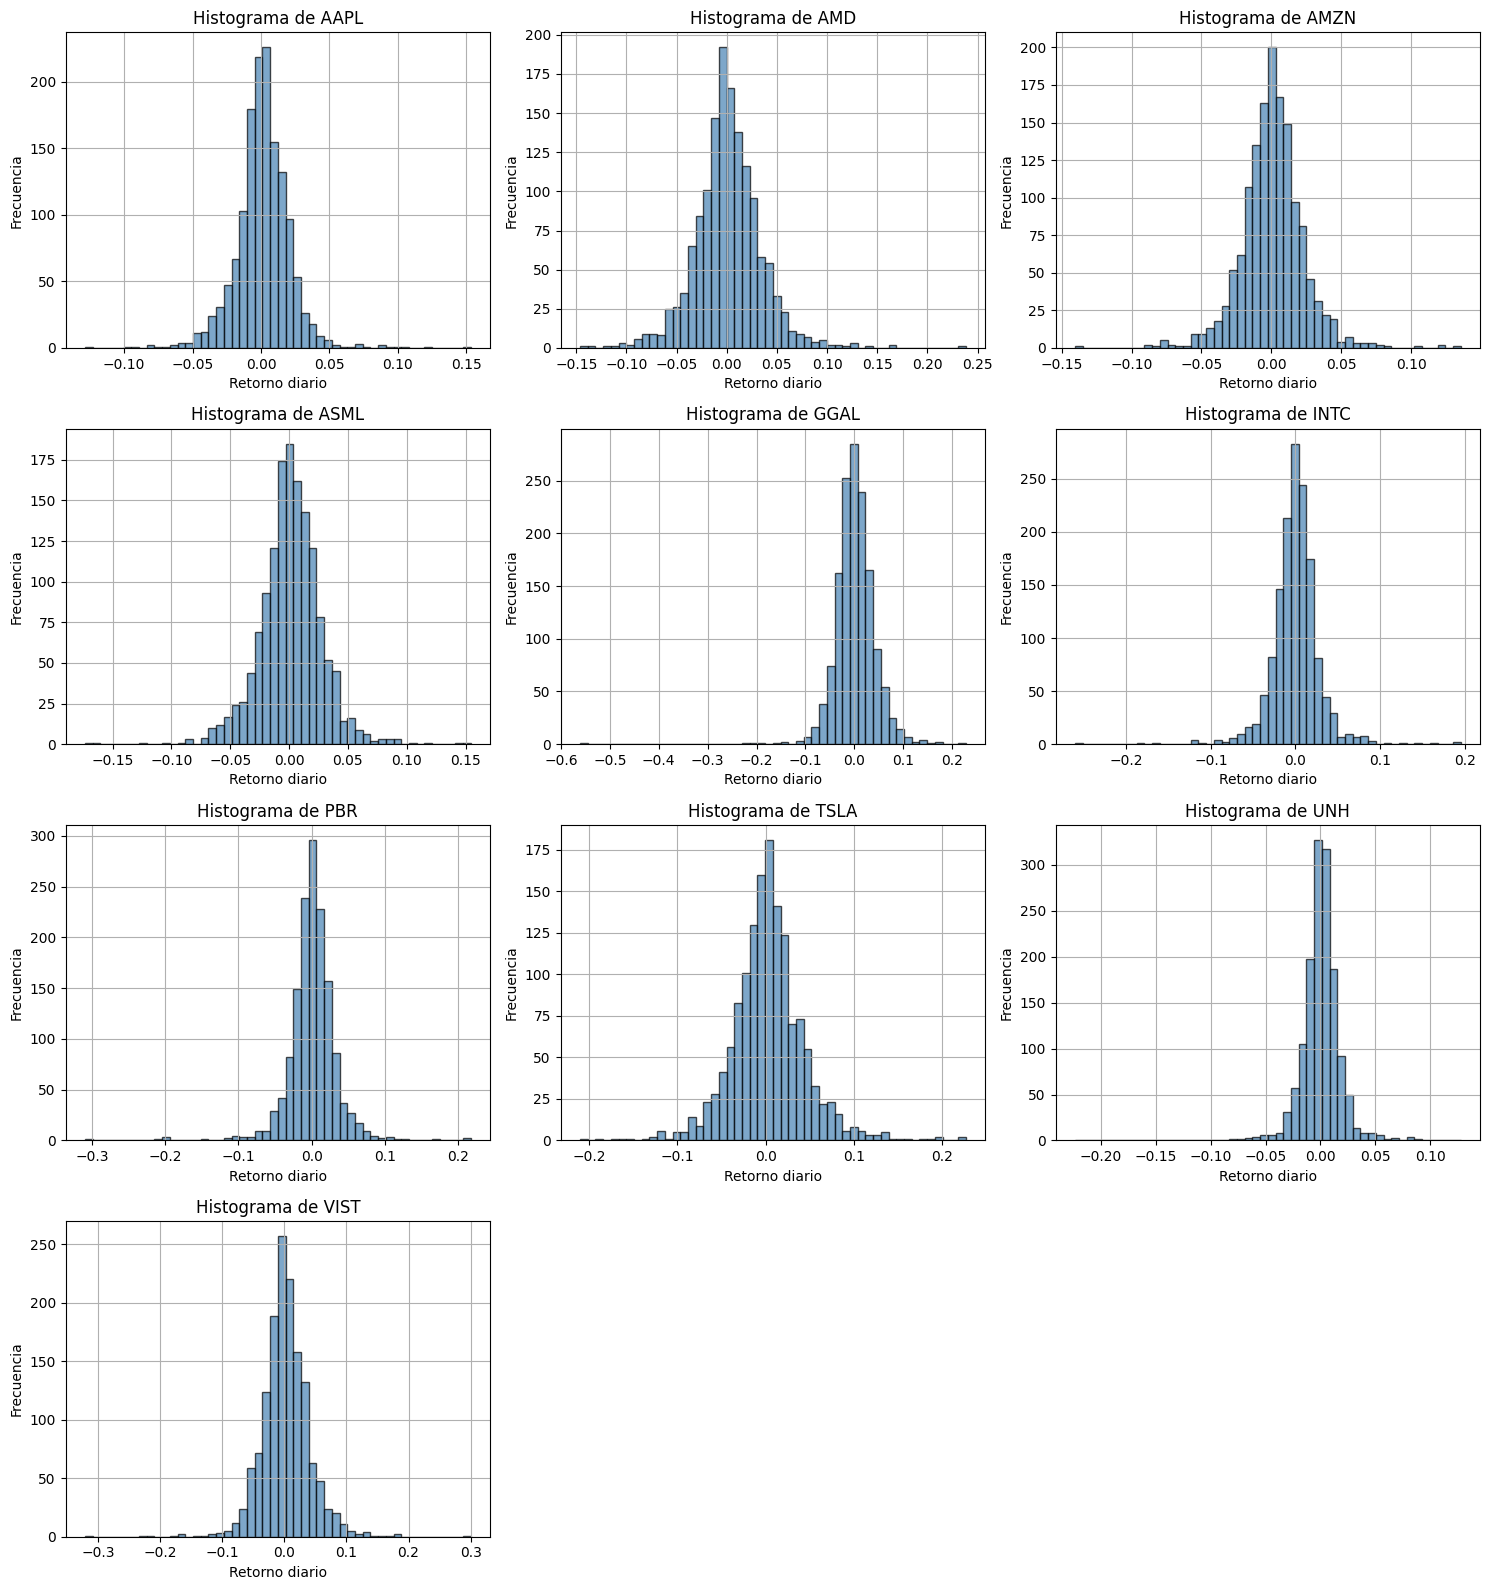

In [12]:
import matplotlib.pyplot as plt

# Número de activos
n = len(returns.columns)
cols = 3  # número de columnas en la grilla
rows = -(-n // cols)  # techo de n / cols para saber cuántas filas

# Crear la figura
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

# Graficar histograma para cada ticker
for i, ticker in enumerate(returns.columns):
    axes[i].hist(returns[ticker], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {ticker}')
    axes[i].set_xlabel('Retorno diario')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [13]:
print(returns.skew())     # Asimetría
print(returns.kurtosis()) # Curtosis


Ticker
AAPL    0.222424
AMD     0.390268
AMZN    0.126628
ASML   -0.172781
GGAL   -1.643230
INTC   -0.280035
PBR    -0.896833
TSLA    0.305116
UNH    -1.151604
VIST   -0.102148
dtype: float64
Ticker
AAPL     6.649975
AMD      3.749800
AMZN     4.413061
ASML     4.385373
GGAL    26.339772
INTC    11.874156
PBR     14.533185
TSLA     3.496201
UNH     21.158545
VIST     7.856300
dtype: float64


## Correlaciones

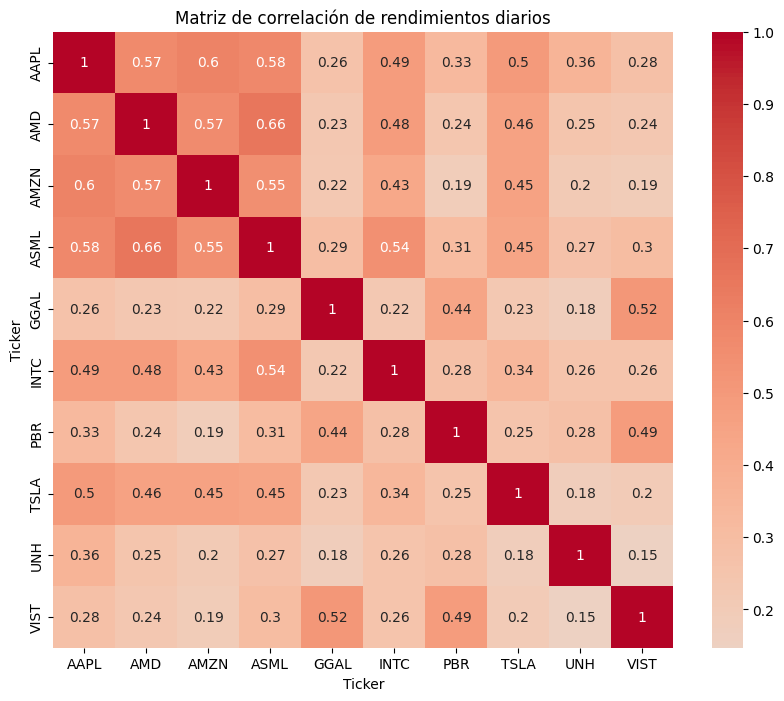

In [14]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación de rendimientos diarios')
plt.show()


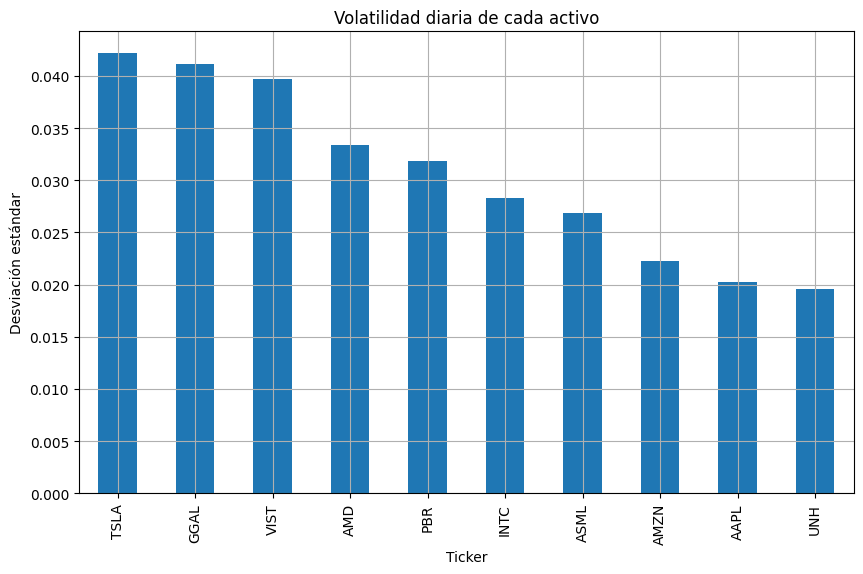

In [15]:
returns.std().sort_values(ascending=False).plot(kind='bar', figsize=(10,6), title="Volatilidad diaria de cada activo")
plt.ylabel("Desviación estándar")
plt.grid(True)
plt.show()


## Betas

/tmp/ipython-input-17-1613425300.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download('QQQ', start=returns.index[0], end=returns.index[-1])['Close']
[*********************100%***********************]  1 of 1 completed


In [23]:
# Intersección de fechas entre returns y qqq_returns
common_index = returns.index.intersection(spy_returns.index)

# Reducimos ambos a las fechas comunes
returns_aligned = returns.loc[common_index]
spy_returns_aligned = spy_returns.loc[common_index]


In [24]:
betas = {}

for ticker in returns_aligned.columns:
    X = sm.add_constant(spy_returns_aligned)
    y = returns_aligned[ticker]

    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    betas[ticker] = beta

# Mostramos los betas
for ticker, beta in betas.items():
    print(f"Beta de {ticker} respecto a SPY: {beta:.2f}")


Beta de AAPL respecto a SPY: 1.21
Beta de AMD respecto a SPY: 1.65
Beta de AMZN respecto a SPY: 1.11
Beta de ASML respecto a SPY: 1.44
Beta de GGAL respecto a SPY: 1.22
Beta de INTC respecto a SPY: 1.30
Beta de PBR respecto a SPY: 1.18
Beta de TSLA respecto a SPY: 1.66
Beta de UNH respecto a SPY: 0.75
Beta de VIST respecto a SPY: 1.22


/tmp/ipython-input-24-3419637401.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/tmp/ipython-input-24-3419637401.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/tmp/ipython-input-24-3419637401.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/tmp/ipython-input-24-3419637401.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

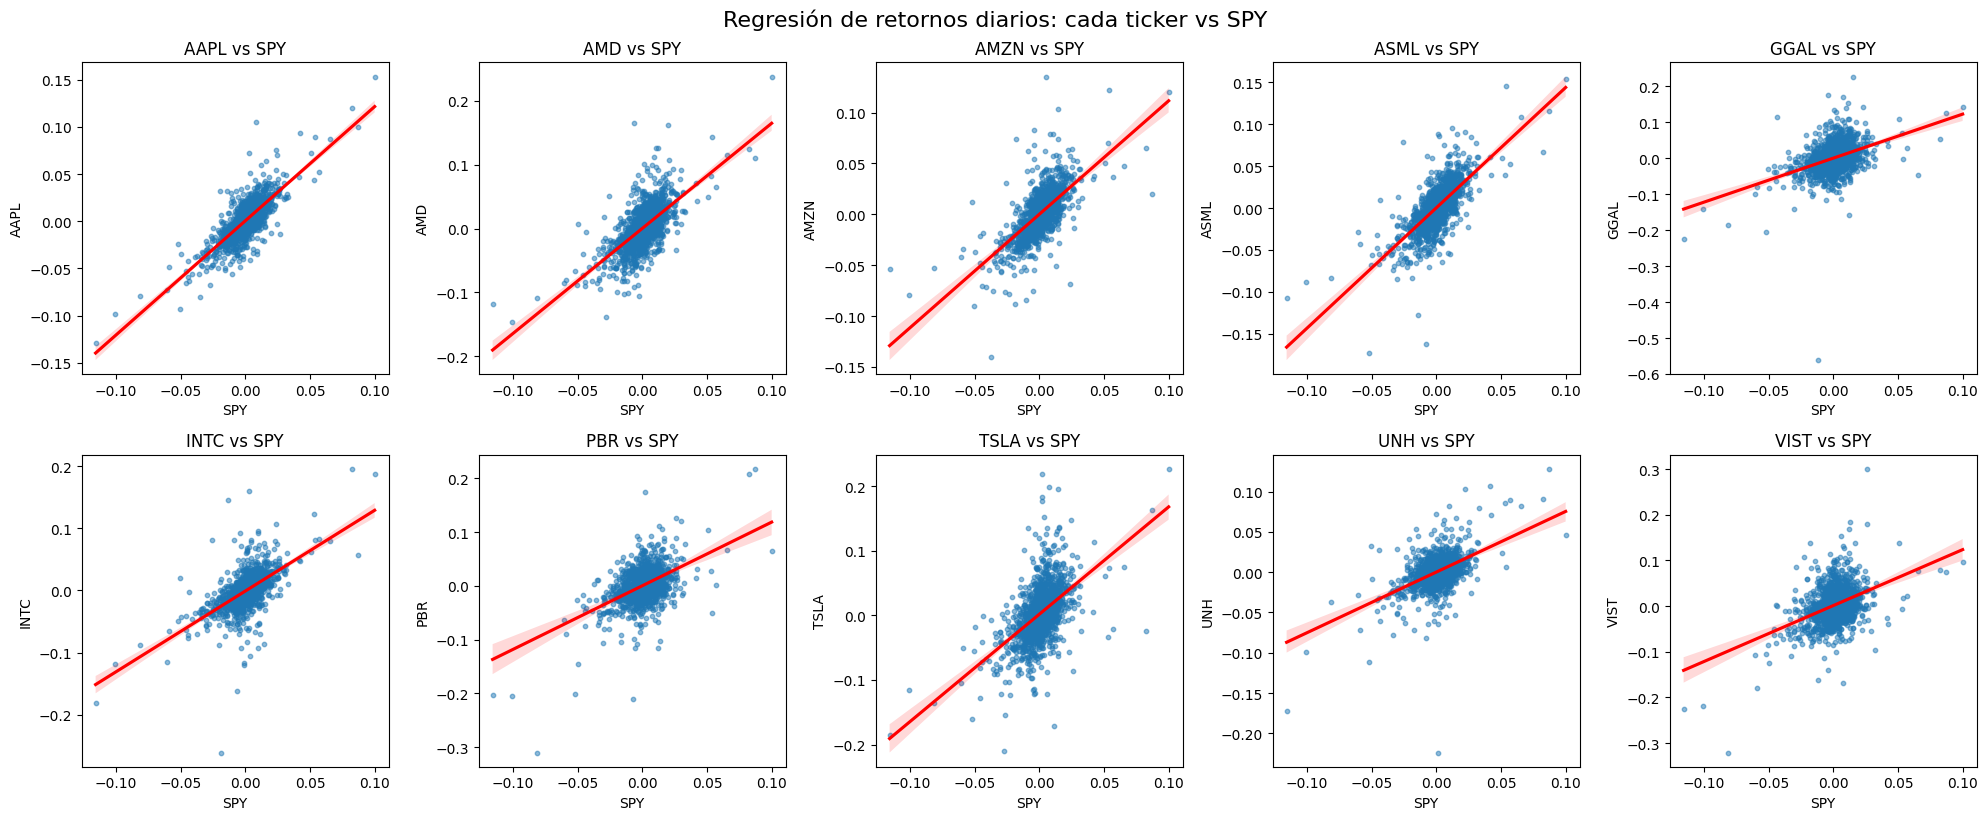

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarnos de alinear los retornos
common_index = returns.index.intersection(spy_returns.index)
returns_aligned = returns.loc[common_index]
spy_returns_aligned = spy_returns.loc[common_index]

# Crear subplots: matriz de 2 filas x 5 columnas (10 tickers)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for i, ticker in enumerate(returns_aligned.columns):
    ax = axs[i]
    sns.regplot(
        x=spy_returns_aligned,
        y=returns_aligned[ticker],
        ax=ax,
        scatter_kws={'s': 10, 'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    ax.set_title(f'{ticker} vs SPY')
    ax.set_xlabel('SPY')
    ax.set_ylabel(ticker)

plt.tight_layout()
plt.suptitle("Regresión de retornos diarios: cada ticker vs SPY", fontsize=16, y=1.02)
plt.show()


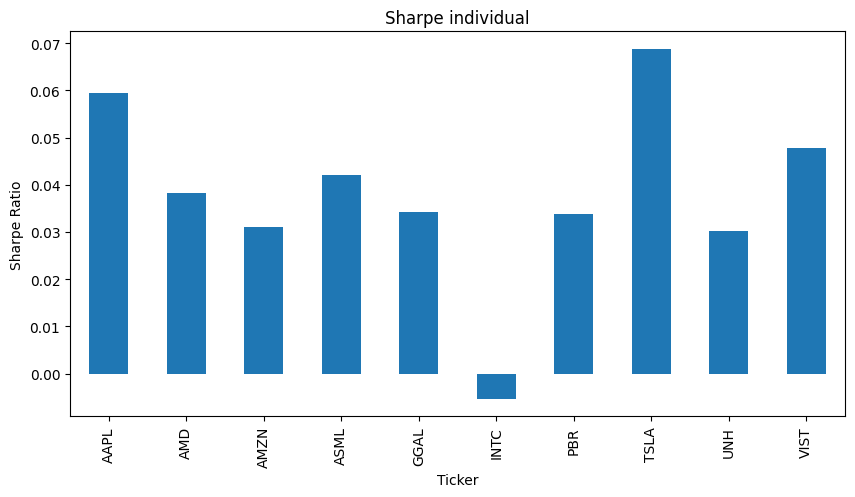

In [27]:
sharpe_individual = returns.mean() / returns.std()
sharpe_individual.plot(kind='bar', figsize=(10,5), title="Sharpe individual")
plt.ylabel("Sharpe Ratio")
plt.show()


# PORTOFLIOS

## Minima varianza

In [28]:
#num_assets = len(tickers)
num_assets = len(mean_returns)


In [29]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))


In [30]:
initial_weights = num_assets * [1. / num_assets]


In [31]:
optimized = minimize(
    fun=min_volatility,
    x0=initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)


In [32]:
optimal_weights = optimized.x
ret_min = portfolio_return(optimal_weights, mean_returns)
vol_min = portfolio_volatility(optimal_weights, cov_matrix)

print("Pesos óptimos del portafolio de mínima varianza:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nRetorno esperado: {ret_min:.2%}")
print(f"Volatilidad esperada: {vol_min:.2%}")


Pesos óptimos del portafolio de mínima varianza:
AAPL: 20.14%
AMD: 0.00%
AMZN: 23.23%
ASML: 0.00%
GGAL: 0.59%
INTC: 4.15%
PBR: 5.28%
TSLA: 0.00%
UNH: 43.33%
VIST: 3.28%

Retorno esperado: 0.06%
Volatilidad esperada: 1.54%


## Maximo rendimiento

In [33]:
def negative_return(weights, mean_returns):
    return -portfolio_return(weights, mean_returns)


In [34]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = num_assets * [1. / num_assets]


In [35]:
optimal_return = minimize(
    fun=negative_return,
    x0=initial_weights,
    args=(mean_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)


In [36]:
ret_weights = optimal_return.x
ret_max = portfolio_return(ret_weights, mean_returns)
vol_max = portfolio_volatility(ret_weights, cov_matrix)

print("Pesos óptimos del portafolio de máximo retorno esperado:")
for ticker, weight in zip(tickers, ret_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nRetorno esperado: {ret_max:.2%}")
print(f"Volatilidad esperada: {vol_max:.2%}")


Pesos óptimos del portafolio de máximo retorno esperado:
AAPL: 0.00%
AMD: 0.00%
AMZN: 0.00%
ASML: 0.00%
GGAL: 61.73%
INTC: 0.00%
PBR: 0.00%
TSLA: 0.00%
UNH: 0.00%
VIST: 38.27%

Retorno esperado: 0.18%
Volatilidad esperada: 3.57%


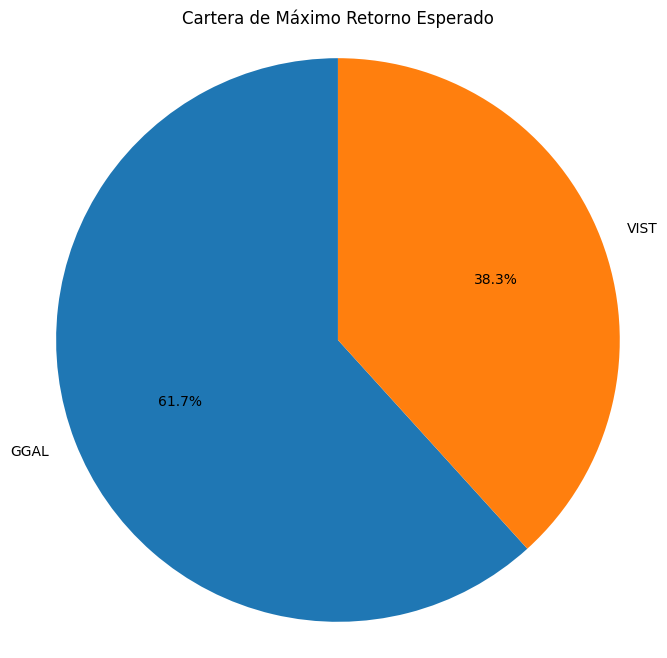

In [37]:
# Filtramos solo activos con peso > 0 para que el gráfico no esté sobrecargado
non_zero_weights = [(t, w) for t, w in zip(tickers, ret_weights) if w > 0.001]
labels, sizes = zip(*non_zero_weights)

# Gráfico
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Cartera de Máximo Retorno Esperado")
plt.axis('equal')  # Para que el círculo sea perfecto
plt.show()

## Maximo sharpe ratio

In [38]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    p_return = portfolio_return(weights, mean_returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (p_return - risk_free_rate) / p_volatility
    return -sharpe_ratio


In [39]:
# Restricción de que la suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Restricción que cada peso sea al menos (maximo) n%
bounds = tuple((0.02, 0.15) for _ in range(num_assets))


#Pesos iniciales iguales
initial_weights = np.array([1.0 / num_assets] * num_assets)


num_assets

10

In [40]:
optimal_sharpe = minimize(
    fun=negative_sharpe_ratio,
    x0=initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

sharpe_weights=optimal_sharpe.x

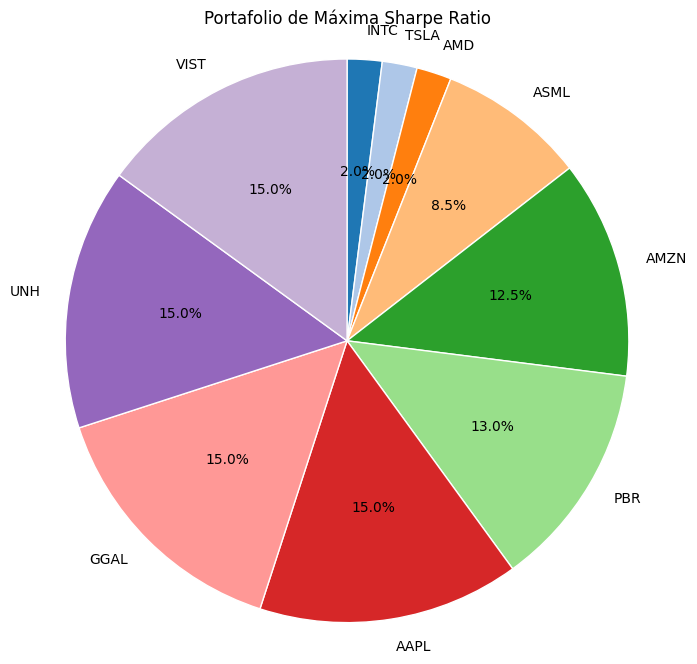

Pesos óptimos del portafolio de máxima Sharpe ratio:
AAPL: 15.00%
AMD: 2.00%
AMZN: 12.51%
ASML: 8.49%
GGAL: 15.00%
INTC: 2.00%
PBR: 12.99%
TSLA: 2.00%
UNH: 15.00%
VIST: 15.00%

Retorno esperado: 0.09%
Volatilidad esperada: 1.93%
Sharpe Ratio esperado: 0.05


In [41]:
# Eliminar acciones con peso muy chico (opcional, para que no quede muy cargado)
filtrar = [(ticker, peso) for ticker, peso in zip(tickers, sharpe_weights) if peso > 0.01]
tickers_filtrados = [t[0] for t in filtrar]
pesos_filtrados = [t[1] for t in filtrar]

# Ordenar de menor a mayor peso
filtrar.sort(key=lambda x: x[1])  # ordena por el segundo elemento (peso)

# Separar nuevamente tickers y pesos
tickers_ordenados = [t[0] for t in filtrar]
pesos_ordenados = [t[1] for t in filtrar]


# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    pesos_ordenados,
    labels=tickers_ordenados,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=plt.cm.tab20.colors,
    wedgeprops={'edgecolor': 'white'}

)
plt.title('Portafolio de Máxima Sharpe Ratio')
plt.axis('equal')  # Para que sea redondo
plt.show()

print("Pesos óptimos del portafolio de máxima Sharpe ratio:")
for ticker, weight in zip(tickers, sharpe_weights):
    print(f"{ticker}: {weight:.2%}")

#Resultados
ret_sharpe = portfolio_return(sharpe_weights, mean_returns)
vol_sharpe = portfolio_volatility(sharpe_weights, cov_matrix)
sharpe_ratio = (ret_sharpe - 0.0) / vol_sharpe
print(f"\nRetorno esperado: {ret_sharpe:.2%}")
print(f"Volatilidad esperada: {vol_sharpe:.2%}")
print(f"Sharpe Ratio esperado: {sharpe_ratio:.2f}")


## Según industria

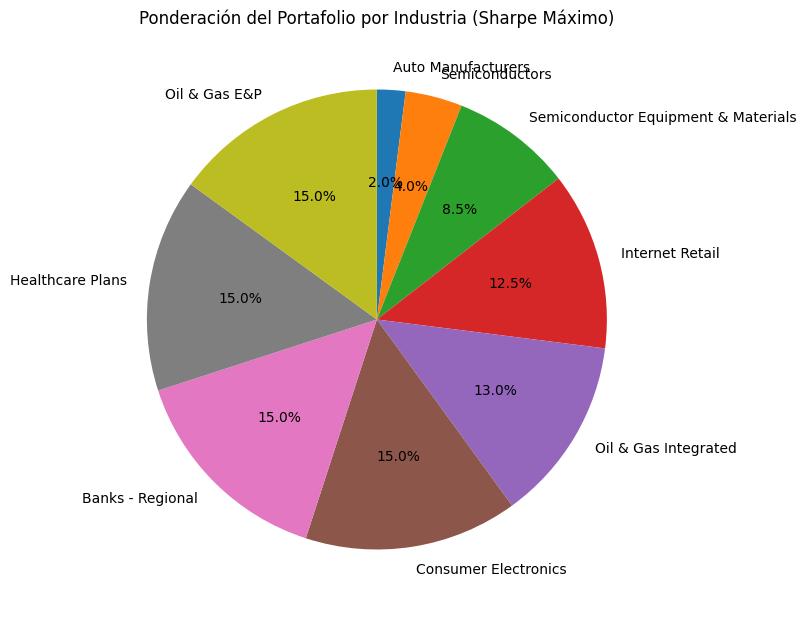

In [42]:
# Paso 1: convertir el array a DataFrame con tickers
weights_df = pd.DataFrame({
    "Ticker": tickers,
    "Weight": sharpe_weights
})


# Paso 2: unir con la industria
weights_with_industry = weights_df.merge(industries_df, on="Ticker")

# Paso 3: agrupar por industria y filtrar las de peso > 0
industry_weights = weights_with_industry.groupby("Industry")["Weight"].sum()
industry_weights = industry_weights[industry_weights > 0.01]

# Paso 3.5: ordenar de menor a mayor para graficar en sentido horario
industry_weights = industry_weights.sort_values(ascending=True)

# Paso 4: graficar en torta
plt.figure(figsize=(8,8))
industry_weights.plot(kind="pie", autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Ponderación del Portafolio por Industria (Sharpe Máximo)")
plt.ylabel("")
plt.tight_layout()
plt.show()


# FRONTERA EFICIENTE

In [43]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # filas: retorno, volatilidad, sharpe

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  # suma 1
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    sharpe = (ret - 0.0) / vol
    results[0,i] = ret
    results[1,i] = vol
    results[2,i] = sharpe


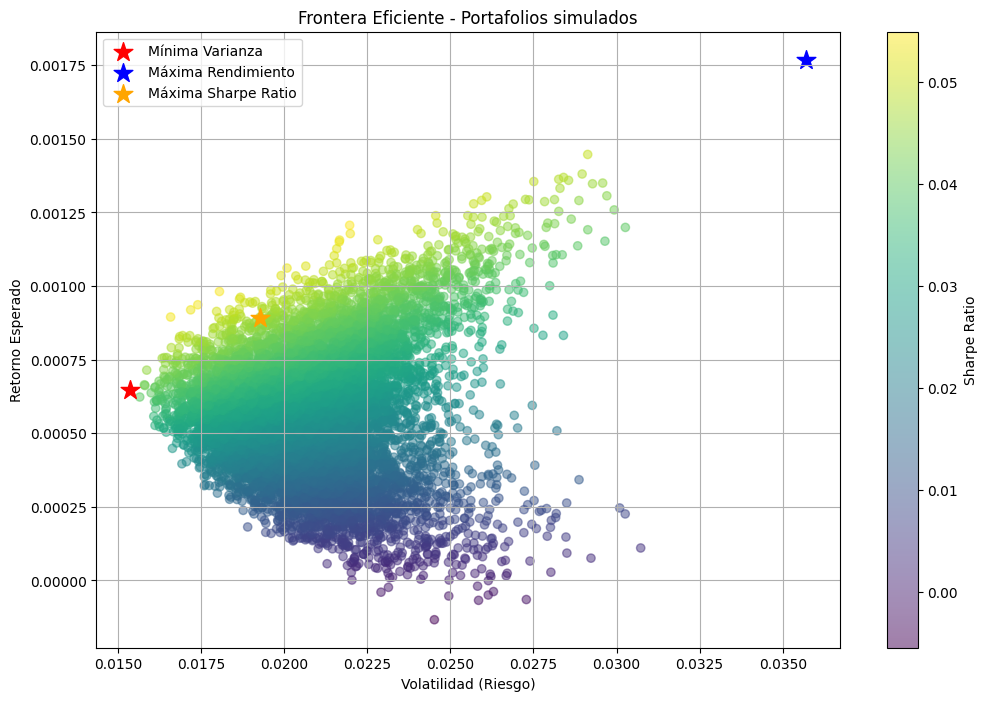

In [44]:
plt.figure(figsize=(12,8))

# Nube de portafolios simulados
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.title('Frontera Eficiente - Portafolios simulados')

# Portafolio de mínima varianza
plt.scatter(vol_min, ret_min, color='red', marker='*', s=200, label='Mínima Varianza')

# Portafolio de máxima Sharpe
plt.scatter(vol_max, ret_max, color='blue', marker='*', s=200, label='Máxima Rendimiento')#

# Portafolio de máxima Sharpe
plt.scatter(vol_sharpe, ret_sharpe, color='orange', marker='*', s=200, label='Máxima Sharpe Ratio')

plt.legend()
plt.grid(True)
plt.show()


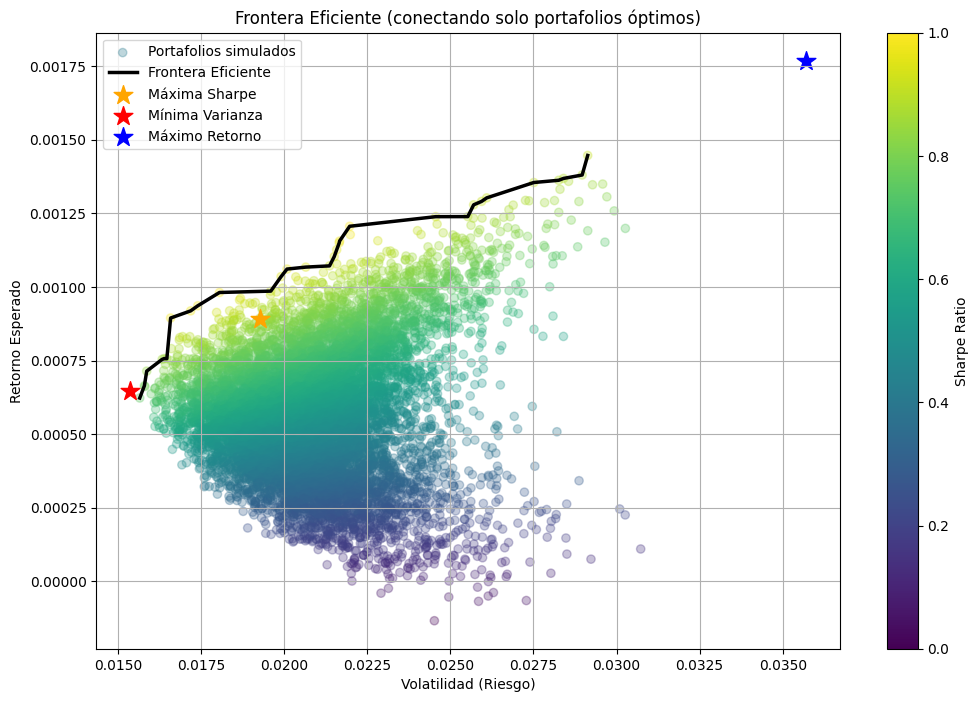

In [45]:
# Convertimos los resultados a DataFrame
df_portfolios = pd.DataFrame(results.T, columns=["Retorno", "Volatilidad", "Sharpe"])
df_sorted = df_portfolios.sort_values("Volatilidad")

# Filtramos la frontera eficiente
frontera_efficient = []
retorno_max = -np.inf

for _, row in df_sorted.iterrows():
    if row["Retorno"] > retorno_max:
        frontera_efficient.append(row)
        retorno_max = row["Retorno"]

# Convertimos a DataFrame
frontera_df = pd.DataFrame(frontera_efficient)

# Graficamos
plt.figure(figsize=(12, 8))

# Nube de portafolios simulados
plt.scatter(df_portfolios['Volatilidad'], df_portfolios['Retorno'],
            c=df_portfolios['Sharpe'], cmap='viridis', alpha=0.3, label='Portafolios simulados')

# Frontera eficiente como línea
plt.plot(frontera_df['Volatilidad'], frontera_df['Retorno'],
         color='black', linewidth=2.5, label='Frontera Eficiente')

# Puntos especiales
plt.scatter(vol_sharpe, ret_sharpe, color='orange', marker='*', s=200, label='Máxima Sharpe')
plt.scatter(vol_min, ret_min, color='red', marker='*', s=200, label='Mínima Varianza')
plt.scatter(vol_max, ret_max, color='blue', marker='*', s=200, label='Máximo Retorno')

# Estética
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.title('Frontera Eficiente (conectando solo portafolios óptimos)')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-46-583846296.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download('QQQ', start=returns.index[0], end=returns.index[-1])['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-46-583846296.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Close']
[*********************100%***********************]  1 of 1 completed


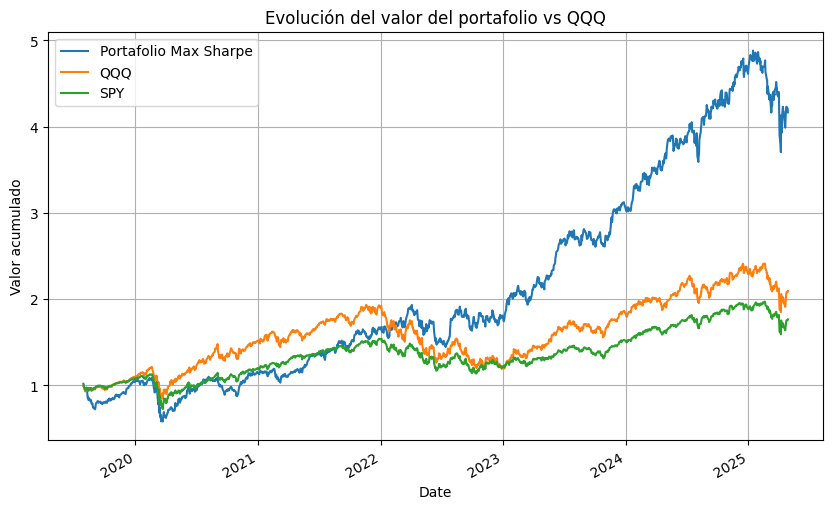

In [46]:
# 1. Descargar datos de QQQ
qqq = yf.download('QQQ', start=returns.index[0], end=returns.index[-1])['Close']

# 2. Calcular retornos diarios y rendimiento acumulado
qqq_returns = np.log(qqq / qqq.shift(1)).dropna()
qqq_cumulative = (1 + qqq_returns).cumprod()

#sp
spy = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Close']

# 2. Calcular retornos diarios y rendimiento acumulado
spy_returns = np.log(spy / spy.shift(1)).dropna()
spy_cumulative = (1 + spy_returns).cumprod()


# 3. Rendimiento acumulado del portafolio
portfolio_returns = (returns * sharpe_weights).sum(axis=1)
portfolio_cumulative = (1 + portfolio_returns).cumprod()

# 4. Alinear fechas por si hay faltantes
combined_df = pd.concat([portfolio_cumulative, qqq_cumulative, spy_cumulative], axis=1).dropna()
combined_df.columns = ['Portafolio Max Sharpe', 'QQQ', 'SPY']

# 5. Graficar
combined_df.plot(figsize=(10,6), title="Evolución del valor del portafolio vs QQQ")
plt.ylabel("Valor acumulado")
plt.grid(True)
plt.show()

